## Benötigte Definitionen für die Hausarbeit

In [9]:
from numpy import *
from matplotlib.pyplot import *
import numpy
import time

### function definitions (will be outsourced) ###
def genMesh(Lx, Ly, nel_x, nel_y, npel, order='r'):
    """Generate a rectangular mesh and it's connectivity matrix.
    Numbering of the elements by default is done horizontally (order=`r`),
    and numbering of the generated gridpoints of an element is done counterclockwise.
    
    Parameters
    ----------
        Lx : scalar     width of the meshed area
        Ly : scalar     height/depth of the meshed area
        nel_x : scalar  number of elements in first dimension
        nel_y : scalar  number of elements in second dimension
        npel : scalar   number of nodes per element
        order : char    'r' or 'c', row major or column major ordering of elements
        
    note: a correct connectivity matrix is yet only guaranteed for a 4 node per element case.
    
    Returns
    -------
        gcoord : array  global coordinates of generated meshpoints(nodes) from 0 to Lx (Ly), dim (2xnelx*nely)
        el2nod : array  connectivity matrix. Indices of meshpoints belonging to an element, dim (npel,nelx*nely)
    """
    s = npel//4
    nx, ny = nel_x*s+1, nel_y*s+1
    nnod = nx*ny
    if order=='r':
        gcoord = vstack((array([(linspace(0,Lx,nx).tolist())*(ny)]), linspace(0,Ly,ny).repeat(nx)))
        indexs = arange(nnod).reshape(ny,nx)
    elif order=='c':
        gcoord = vstack((linspace(0,Lx,nx).repeat(ny), array([(linspace(0,Ly,ny).tolist())*(nx)])))
        indexs = arange(nnod).reshape(nx,ny).T
    else: raise InputError("order must be 'r' or 'c'.")
        
    el2nod = zeros((npel,nel_x*nel_y))
    
    el2nod[0,:] = indexs[:nel_y,:nel_x].flatten()
    el2nod[1*s,:] = indexs[:nel_y,s::s].flatten()
    el2nod[2*s,:] = indexs[s::s,s::s].flatten()
    el2nod[3*s,:] = indexs[s::s,:nel_x].flatten()
    el2nod = el2nod.astype(int).T

    return gcoord, el2nod

def setBoundaryConditions(A, gcoord, el2nod, nel_x, \
                          val_left=array([]),  val_right=array([]), \
                          val_bottom=array([]),val_top=array([]), \
                          exdof=array([])):
    """Returns A after setting it's boundaries to given values.
    
    Parameters
    ----------
        A : array_like      Matrix of which the boundaries are to be set (dim at least 1)
        gcoord : array      2D coordinates of all nodes, dimension: (2xn)
        el2nod : array      connectivity matrix, dimension: (nelxnnodel)
        nel_x : array       number of elements in first dimension
        val_left : scalar or array_like, optional    values to be assigned to the left boundary
        val_right : scalar or array_like, optional   values to be assigned to the right boundary
        val_bottom : scalar or array_like, optional  values to be assigned to the bottom boundary
        val_top : scalar or array_like, optional     values to be assigned to the top boundary
        exdof : array       indices that will be excluded from bcdof
        
    note: If all optional boundaries are given, the corner points of the matrix will
          be set to the values given in val_bottom, or to the values given in val_top, respectively.

    Returns
    -------
        A : array_like      Input matrix with boundaries set to given values
        bcdof : array       Indices of the points assiciated as degree of freedom
        bcval : array       Values of the points referred by `bcdof` indices
    """
    
    nnod = gcoord.shape[1]
    nel_y = int(nnod/(nel_x+1)-1)
    if size(A)%nel_x > 0:
        nel_x += 1
        nel_y += 1
    all_nods = np.arange(nel_x*nel_y).reshape(nel_y,nel_x)#[-1::-1]
    bcdof = array([]).astype(int)
    bcval = array([])
    bcdof_nodes = array([])
    bcval_nodes = array([])
    
    if size(val_left) > 0:
        bcdof = append(bcdof, all_nods[:,0])
        bcval = append(bcval, val_left*np.ones(nel_y))
    if size(val_right) > 0:
        bcdof = append(bcdof, all_nods[:,-1])
        bcval = append(bcval, val_right*np.ones(nel_y))
    if size(val_bottom) > 0:
        bcdof = append(bcdof, all_nods[0,:])
        bcval = append(bcval, val_bottom*np.ones(nel_x))
    if size(val_top) > 0:    
        bcdof = append(bcdof, all_nods[-1,:])
        bcval = append(bcval, val_top*np.ones(nel_x))


    flattened = False
    if A.ndim > 1:
        A = A.flatten()
        flattened = True
    
    # delete free indices
    exclInd = where(isin(bcdof, exdof))
    bcdof = delete(bcdof, exclInd)
    bcval = delete(bcval, exclInd)
    
    # set the boundaries of A 
    A[bcdof] = bcval
    if flattened: A = A.reshape(nel_y, nel_x)
        
    return A, bcdof, bcval

def Ni(xi,eta):
    """Definition of the 2D Shape functions Ni for a 4-node element that sum up to one.
    
    Parameters
    ----------
        xi : scalar or array-like     local coordinates of the first dimension of the integration point(s)
        eta : scalar or array-like    local coordinates of the second dimension of the integration point(s)
        
    Returns
    -------
        array([N1, N2, N3, N4])       shape function values at given local coordinates
    """
    return 0.25*array([(1-xi)*(1-eta), (1+xi)*(1-eta), (1+xi)*(1+eta), (1-xi)*(1+eta)])

def dNi(xi,eta):
    """Definition of the Derivatives of the 2D Shape functions Ni for a 4-node element.
    
    Parameters
    ----------
        xi : scalar or array-like       local coordinates of the first dimension of the integration point(s)
        eta : scalar or array-like      local coordinates of the second dimension of the integration point(s)
        
    Returns
    -------
        array([[dNj/dxi], [dNj/deta]])  partial derivatives of shape functions at given local coordinates
              
    """
    res = vstack((0.25*array([-(1-eta), 1-eta, 1+eta, -(1+eta)]), \
                  0.25*array([-(1-xi), -(1+xi), 1+xi, 1-xi])))
    return res

def calcVel(P, rhof, gcoord, el2nod, K, muf, g):
    """Calculate the Element Velocities according to Darcy's Law v= -K/mu_f *(grad(P)-rho_f *g)
    
    Parameters
    ----------
        P : array           Pressure field, defined nodewise
        rhof : array        density field, defined elementwise
        gcoord : array      2D coordinates of all nodes, dimension: (2xn)
        el2nod : array      connectivity matrix (which nodes belong to which element), dimension: (nelxnnodel)
        K : array           Permeability, defined elementwise
        g : array           gravity components e.g. array([0, -9.81])
    
    Returns
    -------
        V : array          calculated Darcy's velocity components, dimension: (2xnel)
    """
    nel = el2nod.shape[0]
    V = zeros((2, nel))
    dN = dNi(0,0)
    for el in range(nel):
        J = matmul(dN, gcoord[:,el2nod[el]].T)
        dN = linalg.solve(J, dN)
        Kel = array([K[el],0,0,K[el]]).reshape(2,2)/muf
        V[:,el] = matmul(-Kel, matmul(dN, P[el2nod[el]].T) -rhof[el]*g)
    return V

def assembleDiffAdv(gcoord,el2nod, K,muf=1,rho=-1, dt=inf, vel=[], src=[], assTemp=False):
    """Assemble the global matrices L, R and F needed to solve the equation Lx = R+F
    
    Parameters
    ----------
        gcoord : array               2D coordinates of all nodes, dimension: (2xn)
        el2nod : array               connectivity matrix, dimension: (nelxnnodel)
        K : array                    Permeability (or temp. conductivity) of each element forming matrix D (K)
        muf : scalar, optional       Viscosity of the fluid
        rho : array, optional        reference density of fluid, defined elementwise
        dt : scalar, optional        timestep
        vel :  array, optional       Darcy Velocities of each element, dimension (2xnel)
        src :  array, optional       source term, defined nodewise
        assTemp : boolean, optional  whether or not to assemble for temperature (else for pressure)
    
    Returns
    -------
        L,R,F : array_like           assembled matrices L, R and F in the equation Lx = R+F
    """
    from scipy.sparse import csr_matrix
    from scipy.constants import g

    # calculate number of elements, nodes per element and nodes
    nel = el2nod.shape[0]
    nnodel = el2nod.shape[1]
    nnod = gcoord.shape[1]
    
    # transform scalar values into vectors
    if (size(rho)==1 and not assTemp): 
        if rho == -1:
            warnings.warn("Rho not set for Pressure Assembly.", UserWarning)
        rho *= ones(nel)
    if (size(vel)==0 and assTemp):
        warnings.warn("Velocity not set for Temperature Assembly. No Advection is assumed.", UserWarning)
    if size(vel)==1: vel = zeros((2,nel))
    if (size(src)==0 and assTemp): 
        warnings.warn("Sorce not set for Temperature Assembly. No Source Term is assumed.", UserWarning)
        src = zeros(nnod)
    if size(src) == 1: src *= ones(nnod)
    g = array([0, -g])
    
    # define integration points, order: counterclockwise
    nip = nnodel
    xloc, W = numpy.polynomial.legendre.leggauss(int(sqrt(nip)))
    xi = hstack((xloc, xloc[-1::-1]))
    eta= xloc.repeat(2)
    W = outer(W.T, W).flatten()
    
    # global components and indices
    ig = zeros((nnodel**2,nel))
    jg = zeros((nnodel**2,nel))
    Lv = zeros((nnodel**2,nel))
    Rv = zeros((nnodel**2,nel))
    F = zeros(nnod)

    for el in range(nel):
        Me = zeros((nnodel, nnodel))
        Ke = zeros((nnodel, nnodel))
        Ve = zeros((nnodel, nnodel))
        Fe = zeros(nnodel)
        Kel= array([K[el],0,0,K[el]]).reshape(2,2)/muf

        for i in range(nip):
            N = Ni(xi[i],eta[i])
            dN = dNi(xi[i],eta[i])
            J = matmul(dN, gcoord[:,el2nod[el]].T)
            dN = linalg.solve(J, dN)

            Me += outer(N.T, N) *numpy.linalg.det(J) *W[i]
            Ke += matmul( matmul(dN.T,Kel), dN ) *numpy.linalg.det(J) *W[i]
            
            if assTemp:
                Fe += src[el2nod[el]] *N *numpy.linalg.det(J) *W[i]
                Ve += outer( N, matmul(vel[:,el], dN)) *numpy.linalg.det(J) *W[i]
            else:
                Fe += matmul( matmul(dN.T,Kel), g ) *rho[el] *numpy.linalg.det(J) *W[i]

        # Re=0, Lv=Ke for pressure assemble (1/dt = 0)
        Re = 1/dt * Me
        Le = 1/dt * Me + Ke + Ve

        # calc indices of non-zero elements in sparse matrix for element el
        idof = outer(el2nod[el], ones(nnodel))
        jdof = idof.T
        ig[:,el] = idof.flatten()
        jg[:,el] = jdof.flatten()

        Lv[:,el] = Le.flatten()
        Rv[:,el] = Re.flatten()

        F[el2nod[el]] += Fe

    # convert to sparse
    L = csr_matrix((Lv.flatten(), (ig.flatten(), jg.flatten())))
    R = csr_matrix((Rv.flatten(), (ig.flatten(), jg.flatten())))
    return L,R,F

def solveMyT(x, xbcdof, xbcval, l, r, f):
    """Solve Ax = b with the assembled matrices l,r,f including boundaries
    
    Parameters
    ----------
        x : array        solution vector for which the matrix equation will be solved
        xbcdof : array   indices of x at which boundary conditions are set, e.g. those points will be excluded
        xbcval : array   boundary condition values
        l : scipy.sparse.cs[c,r]_matrix  matrix on LHS in lx = r+f
        r : scipy.sparse.cs[c,r]_matrix  matrix on RHS in lx = r+f
        f : array        force vector in equation lx = r+f
        
    Returns
    -------
        x : array       solution vector
    """
    from scipy.sparse.linalg import spsolve
    
    # free indices (not boundary conditioned) at which eqn is solved
    xfree = delete(arange(size(x)), xbcdof)
    lxf = len(xfree)
    
    b = r*x + f
    if xbcdof.any(): b -= l[:,xbcdof]*xbcval
    x[xfree] = spsolve(l[xfree.repeat(lxf), xfree.tolist()*lxf].reshape(lxf,lxf), b[xfree])
    return x

def plotVariable(titl, ax, var, gcoord,el2nod, nelx, t, showQuiv=False, vel=0, ccenter=False):
    """Create a contour plot of `Var` no matter if it's defined per element or per node.
    
    Parameters
    ----------
        titl : string                      name of the variable field `Var`, e.g. 'Temperature'
        ax : matplotlib.axes._axes.Axes    ax object that will be used for the plot
        var : array                        values of the variable field to be plotted
        gcoord : array                     2D coordinates of all nodes, dimension: (2xn)
        nelx : scalar                      number of elements in the first dimension
        t : scalar                         time at which `Var` is plotted
        showQuiv : boolean, optional       if True, a quiver plot will be added to `ax`
        vel : array, optional              2D values used for the quiver plot, e.g. velocities
        ccenter : boolean, optional        if True, the colormap will be centered about 0
    """
    nel_y = int(gcoord.shape[1]/(nelx+1)-1)
    nnod = gcoord.shape[1]
    
    # center of element box for quiver and elementwise variables
    xq = mean(gcoord[0,el2nod[:]], axis=1).reshape(nely,nelx)
    yq = mean(gcoord[1,el2nod[:]], axis=1).reshape(nely,nelx)
    
    # if Variable ist defined for elements
    if size(var) < nnod:
        nx, ny = nelx-1, nely-1
        x = xq
        y = yq
    else:
        nx, ny = nelx, nely
        x = gcoord[0,:].reshape(ny+1,nx+1)
        y = gcoord[1,:].reshape(ny+1,nx+1)
 
    ax.clear()
    suptitle(str(nelx)+'*'+str(nely)+' Elements,  t = '+str(round(t/24/3600, 4))+' d', fontsize=16, y=0.94)
    title(str(titl)+' field')
    xlabel('x [m]'); ylabel('z [m]');
    
    if ccenter:
        vlim = amax(abs(var))
        colorbar(ax.contourf(x, y, var.reshape(ny+1,nx+1), 50, vmax=vlim, vmin=-vlim, cmap='seismic'));
    else:
        colorbar(ax.contourf(x, y, var.reshape(ny+1,nx+1), 50, cmap='seismic'));

    if showQuiv:
        ax.quiver(xq, yq, vel[0].reshape(nely,nelx), vel[1].reshape(nely,nelx),zorder = 4)
    
    xlim([gcoord[0,0], gcoord[0,nelx]])
    ylim([gcoord[1,0], gcoord[1,-1]])#
    

def Inflow(V,T,nelx,nely,el2nod,ifree,bcdofT,TA):
    V_inflow = where(V[1,nelx*(nely-1):] < 0)
    V_inflow = V_inflow[0]+nelx*(nely-1)
    sort_ind = sort(el2nod[V_inflow][:,-2:],axis = None)
    T[sort_ind] = TA
    ifreeT = np.delete(ifree,V_inflow)
    ifreeT = np.delete(ifreeT,bcdofT)
    lifT = len(ifreeT)
    return(T,ifreeT,lifT)

# Konstanten definieren

In [10]:
from scipy.sparse.linalg import spsolve
from IPython import display
from scipy.constants import g

###########           Parameter Definitions            ###########
nelx = 60                  # 1       Anzahl Elemente in x
nely = 30                  # 1       Anzahl Elemente in y
nnodel = 4                 # 1       Knoten pro Element
dtmax = 3600               # s       maximaler Zeitschritt
nt = 3600*24*2             # s       maximaler Berechnungszeitraum
t = 0                      # s       Startzeit der Berechnung
tcount = 0                 # 1       Zähler für die Zeitschleife
Lx = 2000                  # m       Domainlänge in x-Richtung
Ly = 1000                  # m       Domainlänge in y-Richtung
kappa = 1                  # m^2/s   Temperaturleitfähigkeit
K0 = 40e-05                # m^2     Permeabilität
müf = 1                    # Pa s    Viskosität
rho0 = 1000                # kg/m^3  Referenzdichte von Wasser
PA = rho0*g*1800           # P       hydrostatischer Druck am oberen Rand
TA = 4                     # °C      Temperatur am oberen Rand
TB = 200                   # °C      Temperatur am unteren Rand
alpha = 1e-3               # K^-1    Thermischer Ausdehnungskoeffizient
g = array([0,-g])          # m/s^2   Erdbeschleunigung

nel = nelx*nely                      # Gesamtzahl Elemente
nx, ny = nelx+1, nely+1              # Anzahl der Knoten pro Dimension
nnod = nx*ny                         # Gesamtanzahl Knoten
gcoord, el2nod = \
genMesh(Lx,Ly, nelx,nely, nnodel)    # globale Koordinaten und zugehörige Connectivity Matrix
kappa *= ones(nel)                   # Wärmeleitfähigkeit (pro Element)
K = K0*ones(nel)                     # Permeabilität (pro Element)
S = zeros(nnod)                      # Quellterm (pro Knotenpunkt)

myTitels = ['Temperature', 'Density', 'Pressure', 'Abs. Velocity']    # Titel der Variablenfelder
colorCentered = [False, False, True, True]                            # Farbskalazentrierung für Druck und Velocity

# 7.1 Box with impermeable boundaries

In [12]:
### Randbedingungen ###
# 4°C oben, 200°C unten (alternativ dünne Schicht mit Wärmequellen)
T, bcdof,bcval = setBoundaryConditions(zeros(ny*nx), gcoord,el2nod, nelx, val_top=TA, val_bottom=TB)

# kleine Temperaturstörung um die Konvektion zu beschleunigen
ax = gcoord[0].T/Lx
ay = (gcoord[1].T/Ly)**0.5
dT = 0.5 * (1-ay) * (1 + sin(2*pi*10*ax))
T = T + dT


# Rayleigh number
if (-K[len(K)//2]*rho0*alpha*(TB-TA)*Ly*g[1]/müf/kappa[0] < 4*pi**2):
    warnings.warn("For Advection Model the Rayleigh Number should be greater than 4*pi^2.", UserWarning)


# Zeitschleife
t = 0
tcount = 0
figure(figsize=(14, 10))

#while (t <= nt):
for i in range(6):
    rhof = rho0*(1-alpha*mean(T[el2nod[:]], axis=1))
    L, R, b = assembleDiffAdv(gcoord, el2nod, K, muf=müf, rho=rhof)
    P = spsolve(L, b)
    V = calcVel(P, rhof, gcoord,el2nod, K, müf, g)
    # plot first 10 time steps and then every 10th timestep
    if tcount<10 or tcount%10==0:
        myVars = [T, rhof, P, sign(V[1,:])*sqrt(sum(V**2,axis=0))]
        clf()
        for j in range(4):
            plotVariable(myTitels[j], subplot(2,2,j+1), myVars[j], gcoord,el2nod, nelx, t, True, V, colorCentered[j])
        display.display(gcf())
        display.clear_output(wait=True)

    dtmax_adv = 0.05 *min(Lx/amax(abs(V[0,:])), Ly/amax(abs(V[1,:])))
    dt = min(dtmax, dtmax_adv)
    
    L,R,F = assembleDiffAdv(gcoord,el2nod, K=kappa, dt=dt, vel=V, src=S, assTemp=True)
    T = solveMyT(T, bcdof, bcval, L, R, F)
    if amin(T) < -50:
        raise StopIteration('Temperature below -50 °C. Physical meaning of model questionable.')
    
    t += dt;    tcount += 1

Model State after 6 iterations.


# 7.2 Box with permeable upper boundary

In [29]:
#%who
del F, L, R, b, P, T, V, dt, dtmax_adv, rhof

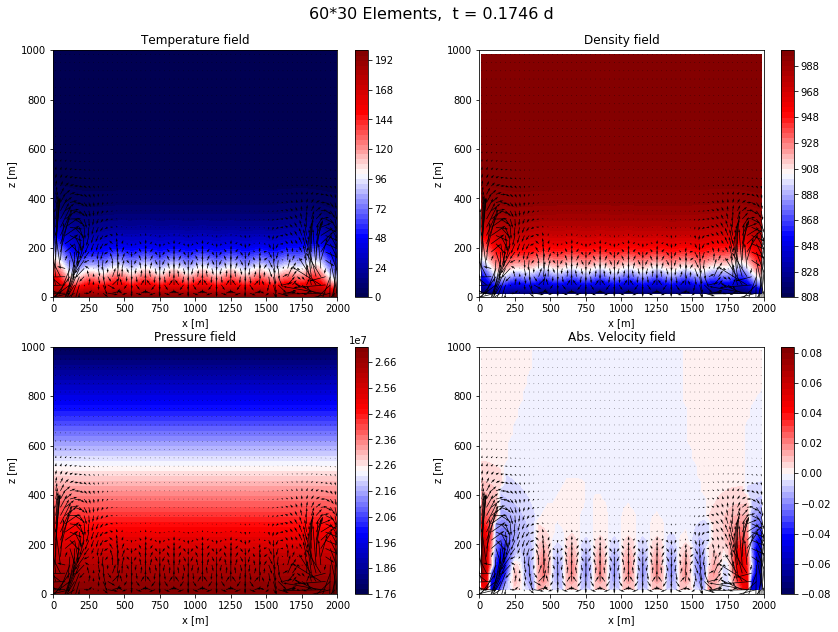

In [29]:
### Randbedingungen ###
P, bcdof_P, bcval_P = setBoundaryConditions(zeros(nnod), gcoord,el2nod, nelx, val_top=PA)
T, bcdof_T, bcval_T = setBoundaryConditions(zeros(nnod), gcoord,el2nod, nelx, val_bottom = TB)

# positiver Druck durch Randbedingung
colorCentered[2] = False
    
# kleine Temperaturstörung um die Konvektion zu beschleunigen
ax = gcoord[0].T/Lx
ay = (gcoord[1].T/Ly)**0.5
dT = 0.5 * (1-ay) * (1 + sin(2*pi*10*ax))
T = T + dT


# Zeitschleife
t = 0
tcount = 0
figure(figsize=(14, 10))

#while (t <= nt):
for i in range(6):
    rhof = rho0*(1-alpha*mean(T[el2nod[:]], axis=1))
    
    L, R, b = assembleDiffAdv(gcoord, el2nod, K, muf=müf, rho=rhof)
    P = solveMyT(P, bcdof_P, bcval_P, L, R, b)
    
    V = calcVel(P, rhof, gcoord,el2nod, K, müf, g)
    #(T,ifree_T,lif_T) = Inflow(V,T,nelx,nely,el2nod,ifree,bcdof_T,TA)
    
    # plot first 10 time steps and then every 10th timestep
    if tcount<10 or tcount%10==0:
        myVars = [T, rhof, P, sign(V[1,:])*sqrt(sum(V**2,axis=0))]
        clf()
        for j in range(4):
            plotVariable(myTitels[j], subplot(2,2,j+1), myVars[j], gcoord,el2nod, nelx, t, True, V, colorCentered[j])
        display.display(gcf())
        display.clear_output(wait=True)

    dtmax_adv = 0.05 *min(Lx/amax(abs(V[0,:])), Ly/amax(abs(V[1,:])))
    dt = min(dtmax, dtmax_adv)
    
    # freie Randbedingung
    T, bcdof_T, bcval_T = setBoundaryConditions(T, gcoord,el2nod, nelx, val_bottom=TB, \
                                                val_top=TA, exdof=where(V[1,:]>0)[0][-nx:])
    L,R,F = assembleDiffAdv(gcoord,el2nod, K=kappa, dt=dt, vel=V, src=S, assTemp=True)
    T = solveMyT(T, bcdof_T,bcval_T, L, R, F)
    
    if amin(T) < -50:
        raise StopIteration('Temperature below -50 °C. Physical meaning of model questionable.')
    
    t += dt;    tcount += 1

# 7.3 Mid Ocean Ridge

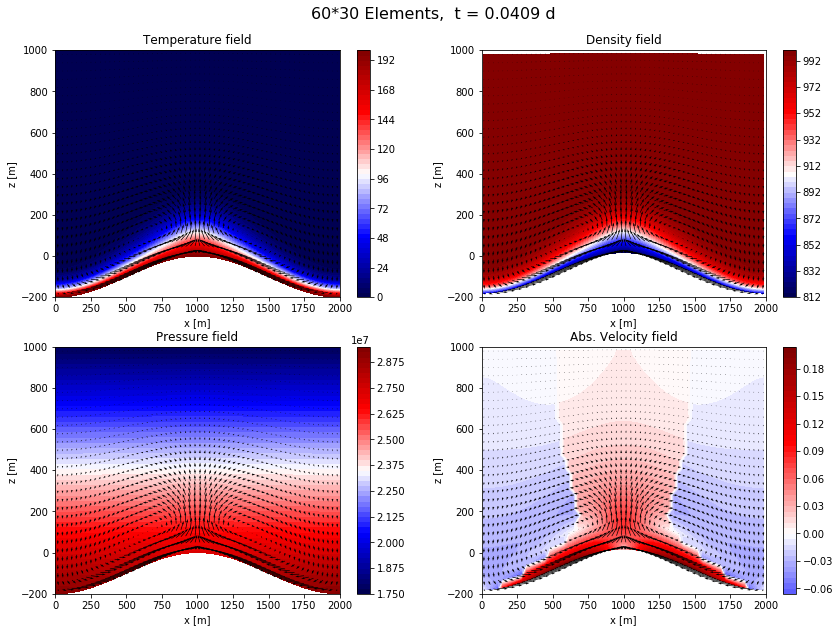

In [30]:
start = time.time()
# Mesh-Verformung (bei Hintereinanderausführung Folgezeile auskommentieren(uncomment))
# gcoord, el2nod = genMesh(Lx,Ly, nelx,nely, nnodel)
ax = -100*(1+cos(2*pi*gcoord[0,:]/Lx))
ay = 1-gcoord[1,:]/Ly
gcoord[1,:] += ax*ay

### Randbedingungen ###
P, bcdof_P, bcval_P = setBoundaryConditions(zeros(nnod), gcoord,el2nod, nelx, val_top=PA)
T, bcdof_T, bcval_T = setBoundaryConditions(zeros(nnod), gcoord,el2nod, nelx, val_bottom=TB)

#myplot = contourf(gcoord[0,:].reshape(ny,nx), gcoord[1,:].reshape(ny,nx), T.reshape(ny,nx), 50, cmap='seismic')
#colorbar();


# Zeitschleife
t = 0
tcount = 0
figure(figsize=(14, 10))

zwischen1 = time.time()
print('Zwischenzeit:',zwischen1-start)
#while (t <= nt):
for i in range(6):
    rhof = rho0*(1-alpha*mean(T[el2nod[:]], axis=1))
    
    L, R, b = assembleDiffAdv(gcoord, el2nod, K, muf=müf, rho=rhof)
    P = solveMyT(P, bcdof_P, bcval_P, L, R, b)
    
    V = calcVel(P, rhof, gcoord,el2nod, K, müf, g)
    
    # plot first 10 time steps and then every 10th timestep
    if tcount<10 or tcount%10==0:
        myVars = [T, rhof, P, sign(V[1,:])*sqrt(sum(V**2,axis=0))]
        clf()
        for j in range(4):
            plotVariable(myTitels[j], subplot(2,2,j+1), myVars[j], gcoord,el2nod, nelx, t, True, V, colorCentered[j])
        display.display(gcf())
        display.clear_output(wait=True)

    dtmax_adv = 0.05 *min(Lx/amax(abs(V[0,:])), Ly/amax(abs(V[1,:])))
    dt = min(dtmax, dtmax_adv)
    
    # freie Randbedingung
    T, bcdof_T, bcval_T = setBoundaryConditions(T, gcoord,el2nod, nelx, val_bottom=TB, \
                                                val_top=TA, exdof=where(V[1,:]>0)[0][-nx:])
    L,R,F = assembleDiffAdv(gcoord,el2nod, K=kappa, dt=dt, vel=V, src=S, assTemp=True)
    T = solveMyT(T, bcdof_T,bcval_T, L, R, F)
    
    if amin(T) < -50:
        raise StopIteration('Temperature below -50 °C. Physical meaning of model questionable.')
    
    t += dt;    tcount += 1
ende = time.time()

In [32]:
print('Rechendauer in s:',ende-start)
print('Anzahl der Durchläufe in der while-Schleife',tcount)

Rechendauer in s: 29.19420552253723
Anzahl der Durchläufe in der while-Schleife 6


In [ ]:
print(min(P)/10**6,max(P)/10**6)